In [1]:
import sys
# Justin's fix of the bad stardust2 setup structure:
#sys.path.append('../../../starDust2')
#import stardust
#from stardust import classify

# Steve's solution:
from stardust2.stardust import classify

from astropy.table import Table
from copy import deepcopy
import pickle
import sncosmo
import numpy as np

from numpy.random import randint
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import snRequiem_stardust_classify as classifier

In [2]:
sndat = classifier.get_lens_model_corrected_photometry(classifier.snphotdata)

In [3]:
sndat

time,band,flux,fluxerr,zp,zpsys,snid,img,mu,muerr,dt
float64,str5,float64,float64,float64,str2,int64,float64,float64,float64,float64
57588.03,f105w,0.02244689019708216,0.005219951440557988,23.9,ab,1,1.1,3.907,0.534,0.0
57486.63,f105w,0.31799214198618075,0.1311611308684628,23.9,ab,2,1.2,7.381,3.044,101.4
57568.729999999996,f105w,0.03482071713147411,0.009002318577156264,23.9,ab,3,1.3,5.02,1.217,19.3
57587.97,f160w,0.15646275915024313,0.024086156875818148,23.9,ab,1,1.1,3.907,0.534,0.0
57486.57,f160w,0.4838775233708169,0.1996504025266793,23.9,ab,2,1.2,7.381,3.044,101.4
57568.67,f160w,0.22440239043824703,0.055109841223682766,23.9,ab,3,1.3,5.02,1.217,19.3


In [4]:
rerun = False
if rerun:
    results = classifier.run_stardust(verbose=False)
else:
    results = pickle.load(open('snReqieum_stardust_classify_results.pkl','rb'))


## Show the STARDUST2 results

referees want to be convinced that this is really 94% likely to be a SNIa.  

Try the following: 
* show a sampling of type Ia light curves (should look like good fits)
* show a sampling of 'best-fit' Type Ibc and II light curves (most are pretty bad)

Next thing to try?
* show some plots of chi2 or log likelihood spread over parameter space? 

<ipython-input-5-a0b23ea51a94>:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("snRequiem_stardust_classify_Ia.png", overwrite=True)


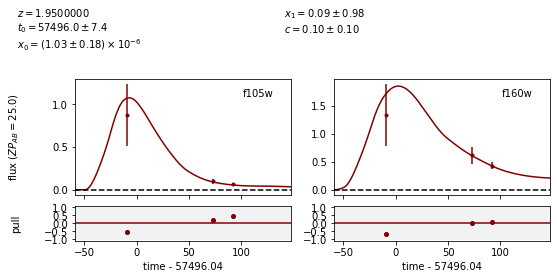

In [5]:
classify.plot_maxlike_fit(results['salt2-extended'], templateset='snana')
plt.savefig("snRequiem_stardust_classify_Ia.png", overwrite=True)


In [5]:
from matplotlib import rcParams


In [6]:
rcParams['legend.shadow']=False
rcParams['legend.fontsize']=30
#rcParams['text.usetex']=True

<ipython-input-9-8b69270f14fd>:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("snRequiem_stardust_classify_alltypes.pdf",


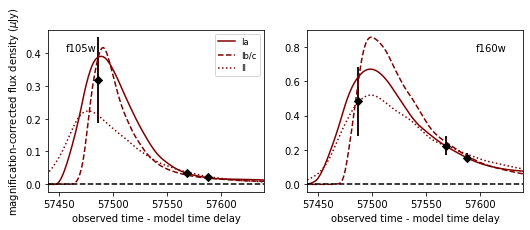

In [9]:
classify.plot_fits(results, nshow=3, templateset='snana', zp=23.9, dpi=300)
fig = plt.gcf()
ax0, ax1 = fig.axes
ax0.set_xlim(57440, 57640)
ax1.set_xlim(57440, 57640)
                       
for ax, band in zip(fig.axes, ['f105w','f160w']):
    iband = np.where(sndat['band']==band)[0]
    ax.errorbar(sndat['time'][iband], sndat['flux'][iband], sndat['fluxerr'][iband],
                marker='D', color='k', ls=' ', ms=5)

ax0.set_ylabel(r'magnification-corrected flux density ($\mu$Jy)', usetex=False)
ax0.set_xlabel(r'observed time - model time delay', usetex=False)
ax1.set_xlabel(r'observed time - model time delay', usetex=False)


plt.savefig("snRequiem_stardust_classify_alltypes.pdf", 
            dpi=300, overwrite=True)

In [10]:
results['pIa'], results['pIbc'], results['pII']           

(0.9370119441810172, 0.006794520281330194, 0.056193535537652294)

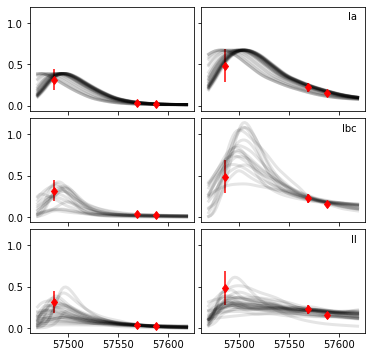

In [7]:
# Set up the axes grid
fig = plt.figure(1, (6., 6.))
axgrid = ImageGrid(fig, 111, nrows_ncols=(3,2), 
                   axes_pad=0.1, aspect=False, share_all=True)


# get the list of names for all CC SN templates used
templatenamesdict = {'Ibc':[k for k in results.keys() 
                            if k in classify.SubClassDict_SNANA['ibc']],
                     'II':[k for k in results.keys() 
                           if k in classify.SubClassDict_SNANA['ii']]
                    }

# The actual SN data:
sn = results['salt2-extended']['sn']

# make a time array for plotting models
t0 =57500  # MJD near first data point
time = np.arange(t0-30, t0+120, 2)


# ====================
# TOP ROW OF AXES: 
axlist = [axgrid[0], axgrid[1]]

# Plot N=30 random samples from the Type Ia nested sampling sequence

# Grab 30 random samples from the Type Ia nested sampling sequence
# We draw from the second half of the sampling sequence to make sure we've settled in to near the likelihood peak
# vparamnames = results['salt2-extended']['res']['vparam_names']
samples = results['salt2-extended']['res']['samples']  # Each sample step gives ['t0', 'x0', 'x1', 'c']
isamples = randint(1200, 2012, size=30)

for band,ax in zip(['f105w','f160w'], axlist):

    # grab x1, c from the nested sampling
    modelfit = results['salt2-extended']['fit']
    for i in isamples:
        t0,x0,x1,c = samples[i]
        modelfit.set(t0=t0,x0=x0,x1=x1,c=c)
        
        # get the flux vs time for this model
        f = modelfit.bandflux(band, time, zp=23.9, zpsys='ab')

        # plot it
        ax.plot(time, f, color='k', alpha=0.1, lw=3)

    # plot the observations
    iband = np.where(sn['band']==band)
    ax.errorbar(sn['time'][iband], sn['flux'][iband], 
                sn['fluxerr'][iband], color='r', marker='d', ls=' ')

    if ax==axlist[-1]:
        ax.text(0.95,0.95, 'Ia', transform=ax.transAxes, ha='right', va='top')

# ====================
# Middle and bottom rows of axes
axesdict = {'Ibc':[axgrid[2], axgrid[3]],
            'II': [axgrid[4], axgrid[5]]}

# Plot max-likelihood light curves for all the Type Ibc and II templates
for sntype in ['Ibc', 'II']:
    tempnamelist = templatenamesdict[sntype]
    axlist = axesdict[sntype]
    for band,ax in zip(['f105w','f160w'], axlist):
        for tempname in tempnamelist:
            modelfit = results[tempname]['fit']

            # get the flux vs time for this model
            f = modelfit.bandflux(band, time, zp=23.9, zpsys='ab')
            # plot it
            ax.plot(time, f, color='k', alpha=0.1, lw=3)
            continue
        # plot the observations
        iband = np.where(sn['band']==band)
        ax.errorbar(sn['time'][iband], sn['flux'][iband], 
                    sn['fluxerr'][iband], color='r', marker='d', ls=' ')
            
        if ax==axlist[-1]:
            ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top')          

# Light curves (Random samples from SALT2 or MLE across all CC templates)

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator


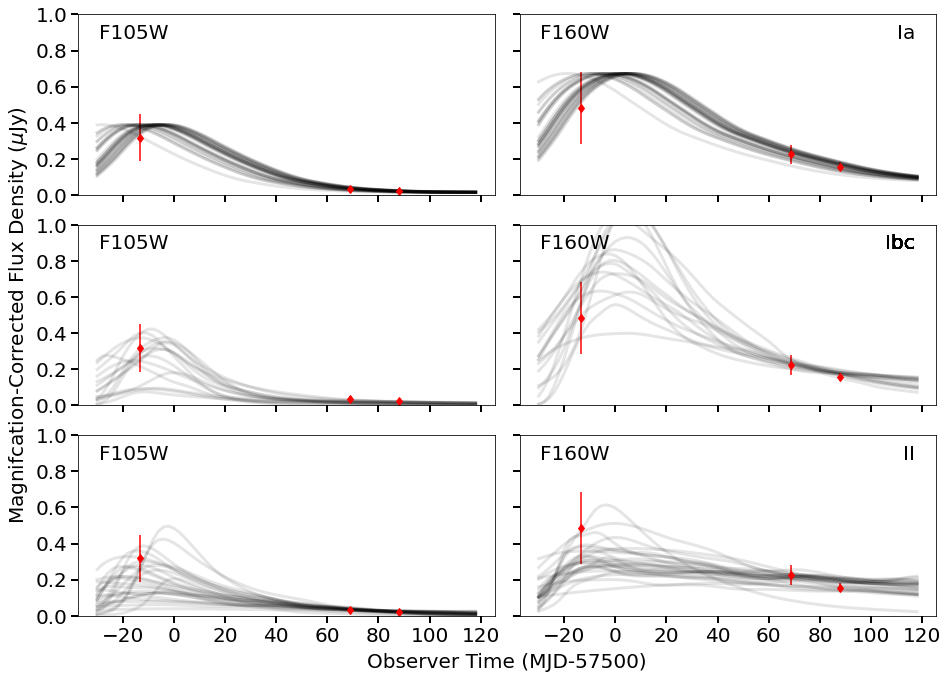

In [8]:
#####LIGHT CURVE WITH MLE FOR CC######
import plot_util
fig,axes,gs = plot_util.grid_plot(3,2,figsize=(14,10),sharex=True,sharey=True)
# The actual SN data:
sn = results['salt2-extended']['sn']

# make a time array for plotting models
t0_init =57500  # MJD near first data point
#time = np.arange(t0-30, t0+120, 2)
time = np.arange(-30, 120, 2)

# ====================
# TOP ROW OF AXES: 
#axlist = [axgrid[0], axgrid[1]]

# Plot N=30 random samples from the Type Ia nested sampling sequence

# Grab 30 random samples from the Type Ia nested sampling sequence
# We draw from the second half of the sampling sequence to make sure we've settled in to near the likelihood peak
# vparamnames = results['salt2-extended']['res']['vparam_names']
samples = results['salt2-extended']['res']['samples']  # Each sample step gives ['t0', 'x0', 'x1', 'c']
isamples = randint(1200, 2002, size=30)


for band,ax in zip(['f105w','f160w'], axes[0][:]):

    # grab x1, c from the nested sampling
    modelfit = results['salt2-extended']['fit']
    for i in isamples:
        t0,x0,x1,c = samples[i]
        modelfit.set(t0=t0,x0=x0,x1=x1,c=c)
        
        # get the flux vs time for this model
        f = modelfit.bandflux(band, time+t0_init, zp=23.9, zpsys='ab')

        # plot it
        ax = plot_util.plot('plot',time, f, color='k', alpha=0.1, lw=3,ticklabelsize=20,
                           fontsize=20,ax=ax)
    if ax==axes[0][-1]:
        ax.text(0.95,0.95, 'Ia', transform=ax.transAxes, ha='right', va='top',fontsize=20)
    # plot the observations
    iband = np.where(sn['band']==band)
    ax.errorbar(sn['time'][iband]-t0_init, sn['flux'][iband], 
                sn['fluxerr'][iband], color='r', marker='d', ls=' ')
    ax.text(0.05,0.95, band.upper(), transform=ax.transAxes, ha='left', va='top',fontsize=20)

# ====================
# Middle and bottom rows of axes

i=0
# Plot max-likelihood light curves for all the Type Ibc and II templates
for sntype in ['Ibc', 'II']:
    tempnamelist = templatenamesdict[sntype]
    i+=1
    for band,ax in zip(['f105w','f160w'], axes[i][:]):
        for tempname in tempnamelist:
            modelfit = results[tempname]['fit']
            # get the flux vs time for this model
            f = modelfit.bandflux(band, time+t0_init, zp=23.9, zpsys='ab')
            # plot it
            ax = plot_util.plot('plot',time, f, color='k', alpha=0.1, lw=3,ticklabelsize=20,
                           fontsize=16,ax=ax)
            if ax==axes[i][-1]:
                ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top',fontsize=20)
            continue
            
        # plot the observations
        iband = np.where(sn['band']==band)
        ax.errorbar(sn['time'][iband]-t0_init, sn['flux'][iband], 
                   sn['fluxerr'][iband], color='r', marker='d', ls=' ')
        ax.text(0.05,0.95, band.upper(), transform=ax.transAxes, ha='left', va='top',fontsize=20)
    
    if ax==axes[-1]:
        #ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top')
        ax.set_xlabel('Observer Time (MJD-%i)'%t0_init,fontsize=20)
ticks=[]
for i in range(3):
    for tick in axes[i][-1].yaxis.get_major_ticks():
        ticks.append('')
    axes[i][-1].set_yticklabels(ticks)
    axes[i][-1].set_ylabel('')
    axes[i][0].set_ylim((0,1))
ticks=[]
for i in range(2):
    for j in range(2):
        for tick in axes[i][j].xaxis.get_major_ticks():
            ticks.append('')
        axes[i][j].set_xticklabels(ticks)
plt.xlabel('Observer Time (MJD-%i)'%t0_init,fontsize=20,labelpad=20)
plt.ylabel('Magnifcation-Corrected Flux Density ($\mu$Jy)',fontsize=20,labelpad=25)
plt.tight_layout()
plt.savefig('lightcurves.pdf',format='pdf')

# Light curves with N random samples (from SALT2 or across all CC templates)

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator


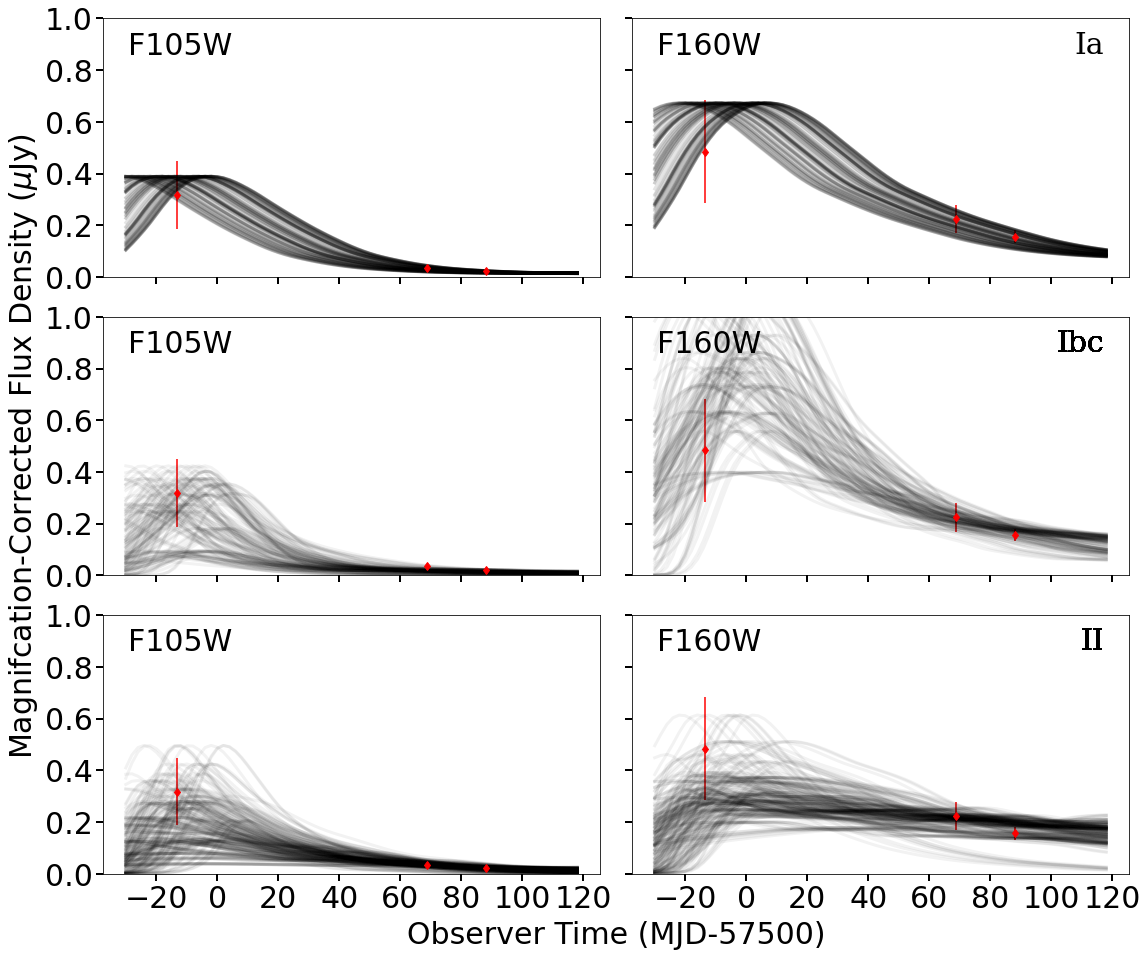

In [15]:
#####LIGHT CURVE WITH N RANDOM SAMPLES######
import plot_util
fig,axes,gs = plot_util.grid_plot(3,2,figsize=(17,14),sharex=True,sharey=True)

fontsize=30


# The actual SN data:
sn = results['salt2-extended']['sn']

# make a time array for plotting models
t0_init =57500  # MJD near first data point
#time = np.arange(t0-30, t0+120, 2)
time = np.arange(-30, 120, 2)
N_Samples = 100
# ====================
# TOP ROW OF AXES: 
#axlist = [axgrid[0], axgrid[1]]

# Plot N=30 random samples from the Type Ia nested sampling sequence

# Grab 30 random samples from the Type Ia nested sampling sequence
# We draw from the second half of the sampling sequence to make sure we've settled in to near the likelihood peak
# vparamnames = results['salt2-extended']['res']['vparam_names']
samples = results['salt2-extended']['res']['samples']  # Each sample step gives ['t0', 'x0', 'x1', 'c']
modelfit = results['salt2-extended']['fit']
weights = results['salt2-extended']['res']['weights']
finite_inds = np.where(np.isfinite(weights))[0]
samples = samples[finite_inds,:]
isamples = randint(0, samples.shape[0], size=N_Samples)

for band,ax in zip(['f105w','f160w'], axes[0][:]):

    # grab x1, c from the nested sampling
    
    for i in isamples:
        t0,x0,x1,c = samples[i]
        modelfit.set(t0=t0,x0=x0,x1=x1,c=c)

        # get the flux vs time for this model
        f = modelfit.bandflux(band, time+t0_init, zp=23.9, zpsys='ab')
        ax = plot_util.plot('plot',time, f, color='k', alpha=0.1, lw=3,ticklabelsize=fontsize,
                           fontsize=20,ax=ax)
    if ax==axes[0][-1]:
        ax.text(0.95,0.95, 'Ia', transform=ax.transAxes, ha='right', va='top',fontsize=fontsize, family='serif')
    # plot the observations
    iband = np.where(sn['band']==band)
    ax.errorbar(sn['time'][iband]-t0_init, sn['flux'][iband], 
                sn['fluxerr'][iband], color='r', marker='d', ls=' ')
    ax.text(0.05,0.95, band.upper(), transform=ax.transAxes, ha='left', va='top',fontsize=fontsize)

# ====================
# Middle and bottom rows of axes

i=0
# Plot max-likelihood light curves for all the Type Ibc and II templates
for sntype in ['Ibc', 'II']:
    tempnamelist = templatenamesdict[sntype]
    i+=1
    for band,ax in zip(['f105w','f160w'], axes[i][:]):
        for tempname in tempnamelist:
            modelfit = results[tempname]['fit']
            samples = results[tempname]['res'].samples
            weights = results[tempname]['res'].weights
            finite_inds = np.where(np.isfinite(weights))[0]
            samples = samples[finite_inds,:]
            randInds = np.random.randint(0,samples.shape[0],N_Per_Template)
            for ind in randInds:
                modelfit.parameters[1:] = samples[ind,:]
                # get the flux vs time for this model
                f = modelfit.bandflux(band, time+t0_init, zp=23.9, zpsys='ab')
                # plot it
                ax = plot_util.plot('plot',time, f, color='k', alpha=0.05, lw=3,ticklabelsize=fontsize,
                                   fontsize=20,ax=ax)
            if ax==axes[i][-1]:
                ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top',fontsize=fontsize, family='serif')
            continue
            
        # plot the observations
        iband = np.where(sn['band']==band)
        ax.errorbar(sn['time'][iband]-t0_init, sn['flux'][iband], 
                   sn['fluxerr'][iband], color='r', marker='d', ls=' ')
        ax.text(0.05,0.95, band.upper(), transform=ax.transAxes, ha='left', va='top',fontsize=fontsize)
    
    if ax==axes[-1]:
        #ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top')
        ax.set_xlabel('Observer Time (MJD-%i)'%t0_init,fontsize=fontsize)
ticks=[]
for i in range(3):
    for tick in axes[i][-1].yaxis.get_major_ticks():
        ticks.append('')
    axes[i][-1].set_yticklabels(ticks)
    axes[i][-1].set_ylabel('')
    axes[i][0].set_ylim((0,1))
ticks=[]
for i in range(2):
    for j in range(2):
        for tick in axes[i][j].xaxis.get_major_ticks():
            ticks.append('')
        axes[i][j].set_xticklabels(ticks)
plt.xlabel('Observer Time (MJD-%i)'%t0_init,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Magnifcation-Corrected Flux Density ($\mu$Jy)',fontsize=fontsize,labelpad=fontsize+10)
plt.tight_layout()
plt.savefig('lightcurves_NSAMPLES.pdf',format='pdf')

# Color curves (N from SALT2 or MLE across all CC templates)

<ipython-input-39-60f9f6e77adf>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(ticks)
<ipython-input-39-60f9f6e77adf>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(ticks)


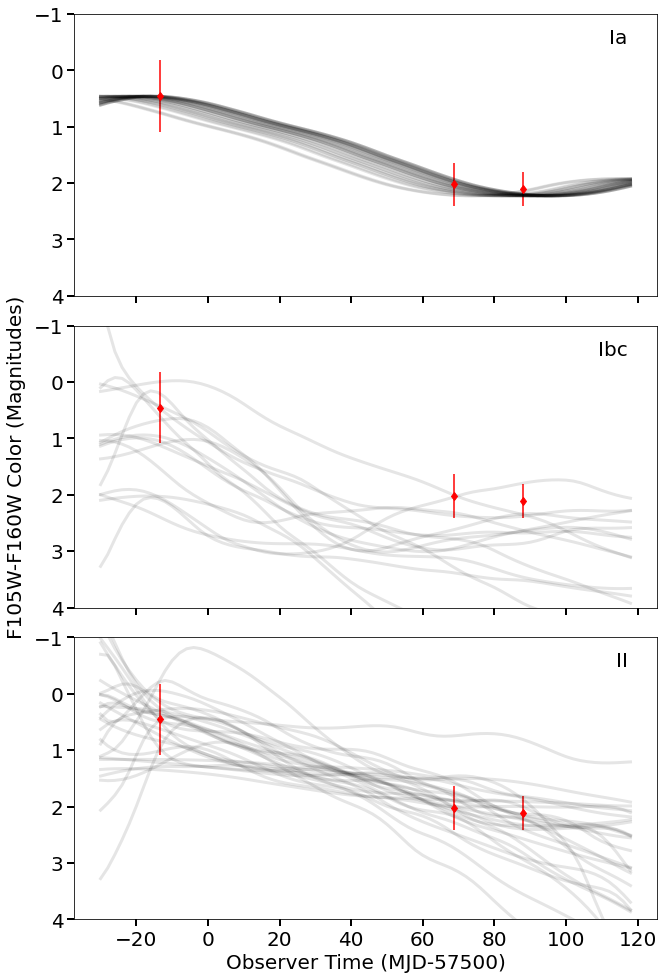

In [39]:
#####COLOR CURVE with MLE for CC#######
import plot_util
fig,axes,gs = plot_util.grid_plot(3,1,figsize=(10,14),sharex=True,sharey=True)
# The actual SN data:
sn = results['salt2-extended']['sn']

# make a time array for plotting models
t0_init =57500  # MJD near first data point
time = np.arange(-30, 120, 2)


# ====================
# TOP ROW OF AXES: 
axlist = [axgrid[0], axgrid[1]]

# Plot N=30 random samples from the Type Ia nested sampling sequence

# Grab 30 random samples from the Type Ia nested sampling sequence
# We draw from the second half of the sampling sequence to make sure we've settled in to near the likelihood peak
# vparamnames = results['salt2-extended']['res']['vparam_names']
samples = results['salt2-extended']['res']['samples']  # Each sample step gives ['t0', 'x0', 'x1', 'c']
isamples = randint(1200, 2002, size=30)


# grab x1, c from the nested sampling
modelfit = results['salt2-extended']['fit']
for i in isamples:
    t0,x0,x1,c = samples[i]
    modelfit.set(t0=t0,x0=x0,x1=x1,c=c)

    # get the flux vs time for this model
    f = modelfit.color('F105W','F160W', 'ab',time+t0_init)
    axes[0]=plot_util.plot('plot',time, f, color='k', alpha=0.1, lw=3,ticklabelsize=20,
                           fontsize=20,ax=axes[0])
    # plot it
    #axes[0].plot(time, f, color='k', alpha=0.1, lw=3)

# plot the observations
iband = np.where(sn['band']=='f105w')
jband = np.where(sn['band']=='f160w')
mags = -2.5*np.log10(sn['flux'])+23.9
magerrs=1.0857*sn['fluxerr']/sn['flux']
finalmagerrs = np.sqrt(magerrs[iband]**2+magerrs[jband]**2)
axes[0].errorbar(sn['time'][iband]-t0_init,mags[iband]-mags[jband], 
    finalmagerrs, color='r', marker='d', ls=' ')
axes[0].invert_yaxis()
axes[0].set_ylim((4,-1))
ticks=[]
for tick in axes[0].xaxis.get_major_ticks():
    ticks.append('')
axes[0].set_xticklabels(ticks)
axes[1].set_xticklabels(ticks)
axes[0].text(0.95,0.95, 'Ia', transform=axes[0].transAxes, ha='right', va='top',fontsize=20)
# ====================
# Middle and bottom rows of axes

i=1
# Plot max-likelihood light curves for all the Type Ibc and II templates
for sntype in ['Ibc', 'II']:
    tempnamelist = templatenamesdict[sntype]
    ax=axes[i]
    i+=1
    for tempname in tempnamelist:
        modelfit = results[tempname]['fit']

        # get the flux vs time for this model
        f = modelfit.color('F105W','F160W', 'ab',time+t0_init)
        # plot it
        ax = plot_util.plot('plot',time, f, color='k', alpha=0.1, lw=3,ticklabelsize=20,
                           fontsize=20,ax=ax)
        continue
    # plot the observations
    #iband = np.where(sn['band']==band)
    #ax.errorbar(sn['time'][iband], sn['flux'][iband], 
    #            sn['fluxerr'][iband], color='r', marker='d', ls=' ')
    
    ax.errorbar(sn['time'][iband]-t0_init,mags[iband]-mags[jband], 
        finalmagerrs, color='r', marker='d', ls=' ')
    ax.invert_yaxis()
    ax.set_ylim((4,-1))
    if ax==axes[-1]:
        #ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top')
        ax.set_xlabel('Observer Time (MJD-%i)'%t0_init,fontsize=20)
    ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top',fontsize=20)
plt.ylabel('F105W-F160W Color (Magnitudes)',fontsize=20,labelpad=25)
plt.tight_layout()
plt.savefig('colorcurves.pdf',format='pdf')

# Color curves with N random samples (from SALT2 or across all CC templates)

/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/usr/local/anaconda3/envs/astroconda/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


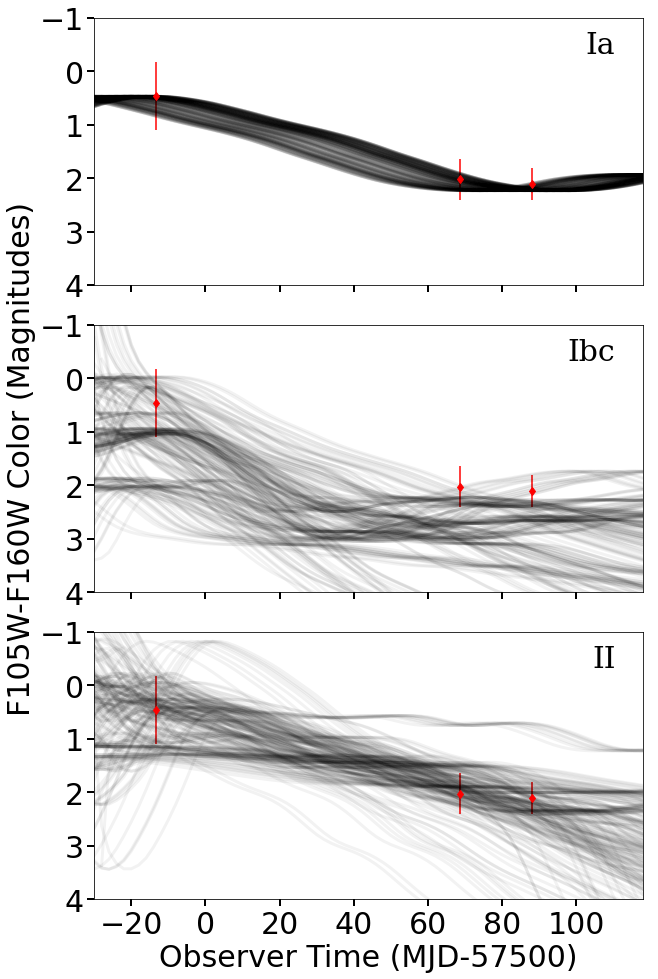

In [13]:
#####COLOR CURVE with N random samples#######
import plot_util
np.random.seed(3)
#fig,axes,gs = plot_util.grid_plot(3,1,figsize=(2.2,3.9),sharex=True,sharey=True)
fig,axes,gs = plot_util.grid_plot(3,1,figsize=(10,14),sharex=True,sharey=True)
fontsize = 30

# The actual SN data:
sn = results['salt2-extended']['sn']

# make a time array for plotting models
t0_init =57500  # MJD near first data point
time = np.arange(-30, 120, 2)
N_Samples = 250

# ====================
# TOP ROW OF AXES: 
axlist = [axgrid[0], axgrid[1]]

# Plot N=30 random samples from the Type Ia nested sampling sequence

# Grab 30 random samples from the Type Ia nested sampling sequence
# We draw from the second half of the sampling sequence to make sure we've settled in to near the likelihood peak
# vparamnames = results['salt2-extended']['res']['vparam_names']
samples = results['salt2-extended']['res']['samples']  # Each sample step gives ['t0', 'x0', 'x1', 'c']
weights = results['salt2-extended']['res']['weights']
finite_inds = np.where(np.isfinite(weights))[0]
samples = samples[finite_inds,:]
isamples = randint(0, samples.shape[0], size=N_Samples)


# grab x1, c from the nested sampling
modelfit = results['salt2-extended']['fit']
for i in isamples:
    t0,x0,x1,c = samples[i]
    modelfit.set(t0=t0,x0=x0,x1=x1,c=c)

    # get the flux vs time for this model
    f = modelfit.color('F105W','F160W', 'ab',time+t0_init)
    axes[0]=plot_util.plot('plot',time, f, color='k', alpha=0.05, lw=3,ticklabelsize=fontsize,
                           fontsize=fontsize,ax=axes[0])
    # plot it
    #axes[0].plot(time, f, color='k', alpha=0.1, lw=3)

# plot the observations
iband = np.where(sn['band']=='f105w')
jband = np.where(sn['band']=='f160w')
mags = -2.5*np.log10(sn['flux'])+23.9
magerrs=1.0857*sn['fluxerr']/sn['flux']
finalmagerrs = np.sqrt(magerrs[iband]**2+magerrs[jband]**2)
axes[0].errorbar(sn['time'][iband]-t0_init,mags[iband]-mags[jband], 
    finalmagerrs, color='r', marker='d', ls=' ')
axes[0].invert_yaxis()
axes[0].set_ylim((4,-1))
ticks=[]
for tick in axes[0].xaxis.get_major_ticks():
    ticks.append('')
axes[0].set_xticklabels(ticks)
axes[1].set_xticklabels(ticks)
axes[0].text(0.95,0.95, 'Ia', transform=axes[0].transAxes, ha='right', va='top',fontsize=fontsize, family='serif')
axes[0].set_xlim((time[0],time[-1]))
# ====================
# Middle and bottom rows of axes

i=1
# Plot max-likelihood light curves for all the Type Ibc and II templates
for sntype in ['Ibc', 'II']:
    tempnamelist = templatenamesdict[sntype]
    N_Per_Template = int(N_Samples/len(tempnamelist))
    ax=axes[i]
    i+=1
    for tempname in tempnamelist:
        modelfit = results[tempname]['fit']
        samples = results[tempname]['res'].samples
        weights = results[tempname]['res'].weights
        finite_inds = np.where(np.isfinite(weights))[0]
        samples = samples[finite_inds,:]
        randInds = np.random.randint(0,samples.shape[0],N_Per_Template)
        for ind in randInds:
            modelfit.parameters[1:] = samples[ind,:]
            # get the flux vs time for this model
            f = modelfit.color('F105W','F160W', 'ab',time+t0_init)
            # plot it
            ax = plot_util.plot('plot',time, f, color='k', alpha=0.05, lw=3,ticklabelsize=fontsize,
                               fontsize=fontsize,ax=ax)
    # plot the observations
    #iband = np.where(sn['band']==band)
    #ax.errorbar(sn['time'][iband], sn['flux'][iband], 
    #            sn['fluxerr'][iband], color='r', marker='d', ls=' ')
    
    ax.errorbar(sn['time'][iband]-t0_init,mags[iband]-mags[jband], 
        finalmagerrs, color='r', marker='d', ls=' ')
    ax.invert_yaxis()
    ax.set_ylim((4,-1))
    if ax==axes[-1]:
        #ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top')
        ax.set_xlabel('Observer Time (MJD-%i)'%t0_init,fontsize=fontsize)
    ax.text(0.95,0.95, sntype, transform=ax.transAxes, ha='right', va='top',fontsize=fontsize, family='serif')
    ax.set_xlim((time[0],time[-1]))
plt.ylabel('F105W-F160W Color (Magnitudes)',fontsize=fontsize,labelpad=35)
plt.tight_layout()
plt.savefig('colorcurves_NSAMPLES.pdf',format='pdf')

# STOP

In [15]:
def rescale_likelihood( a ):
	"""
	Rescale the likelihood array using 
	a Sorted Cumulative Sum function (e.g., for making contours)
	Construct an array "sumabove" such that the cell 
	at index i in sumabove is equal to the sum of all 
	cells from the input array "a" that have a
	cell value higher than a[i]
	"""
	# Collapse the array into 1 dimension
	sumabove = deepcopy(a).ravel()

	# Sort the raveled array by descending cell value
	iravelsorted = sumabove.argsort( axis=0 )[::-1]

	# Reassign each cell to be the cumulative sum of all
	# input array cells with a higher value :
	sumabove[iravelsorted] = sumabove[iravelsorted].cumsum()

	# Normalize by the max value in the array
	sumabove /= sumabove.max()

	# Now unravel back into shape of original array and return
	return( sumabove.reshape( a.shape ) )

KeyboardInterrupt: 

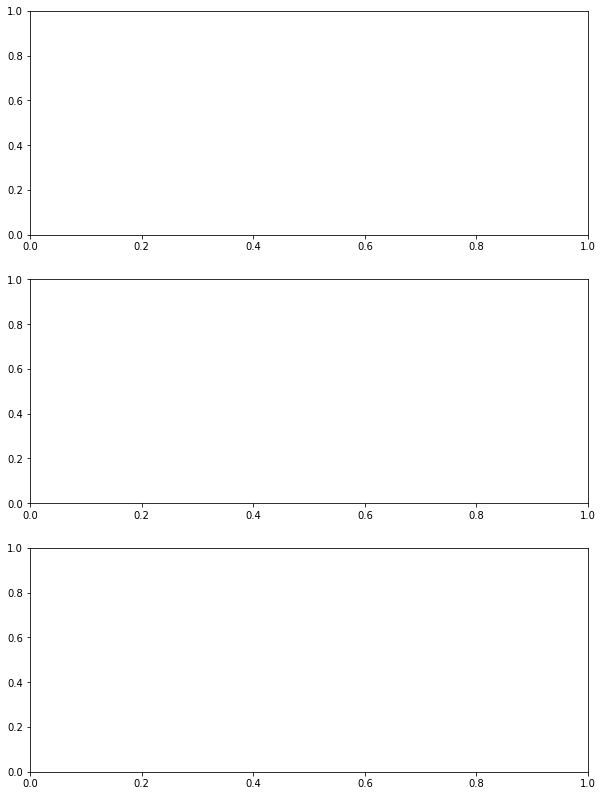

In [16]:
import scipy,plot_util
plt.close()
fig,axes,gs = plot_util.grid_plot(3,1,figsize=(10,14),sharex=True,sharey=True)
t0_init =57500  # MJD near first data point
time = np.arange(-30, 120, 2)
i=1
grid_time=np.linspace(-30,120,1000)
grid_fluxes=np.linspace(0,1.5,1000)
band='f160w'
for sntype in ['Ibc', 'II']:
    ax=axes[i]
    i+=1
    tempnamelist = templatenamesdict[sntype]
    all_times=[]
    all_fluxes=[]
    all_probs=[]
    for tempname in tempnamelist:
        modelfit = results[tempname]['fit']
        # get the flux vs time for this model
        
        samples = results[tempname]['res'].samples
        weights = results[tempname]['res'].weights
        
        for k in np.random.randint(0,len(samples),size=100):
            modelfit.parameters[1:]=samples[k,:]
            f = modelfit.bandflux(band, grid_time+t0_init, zp=23.9, zpsys='ab')
            all_times=np.append(all_times,grid_time)
            all_fluxes=np.append(all_fluxes,f)
            all_probs=np.append(all_probs,[weights[i]]*len(grid_time))
    grid_probs=[]
   
    for j in range(len(grid_time)):
        
        temp=scipy.interpolate.griddata(np.array([all_times,all_fluxes]).T,
                                                             all_probs,
                    np.array([[grid_time[i]]*len(grid_fluxes),grid_fluxes]).T,
                                       fill_value=0)
        #temp = rescale_likelihood(temp)
        grid_probs.append(temp)
    
    #grid_probs=np.array(grid_probs).reshape([len(grid_probs),len(grid_probs)])
    grid_probs=rescale_likelihood(np.array(grid_probs))
    CS=ax.contourf(grid_time, 
                   grid_fluxes, 
                   np.array(grid_probs), colors='k',
                levels=[0,.68], alpha=.8, zorder=10)
    
    #ax.errorbar(sn['time'][iband]-t0_init,mags[iband]-mags[jband], 
    #    finalmagerrs, color='r', marker='d', ls=' ')
    plt.show()
    sys.exit()

In [ ]:
print(grid_probs)

In [ ]:
len(all_times)